In [1]:
import shnitsel as sh
import shnitsel.xarray
import xarray as xr
from IPython.display import display, Image

In [2]:
A01 = sh.open_frames('/nc/reports/2025-05-21_datasheets/filtered_C2H4.nc')
I01 = sh.open_frames('/nc/SHNITSEL_databases/dynamic/I01_ch2nh2_dynamic.nc')
A02 = sh.open_frames('/nc/reports/2025-05-21_datasheets/filtered_C3H6.nc')
A03 = sh.open_frames('/nc/reports/2025-05-21_datasheets/filtered_C4H8_g0.nc')

## Complete workflow for all ensembles

In [ ]:
limits = dict(CC=2, HC=2, CN=2, HN=2)
cpnds = {'I01': I01, 'A01': A01, 'A02': A02, 'A03': A03}
lengths = {}
cutoffs = {}
masks = {}
filtered = {}
truncated = {}
for c in cpnds:
    lengths[c] = cpnds[c].atXYZ.sh.get_bond_lengths()
    masks[c] = lengths[c] < lengths[c].sh.msel(**limits)
    
    # Filter out trajectories with cleavages:
    stayed_intact = masks[c].all('bond').groupby('trajid').all()
    filtered[c] = cpnds[c].sh.sel_trajs(stayed_intact)
    filtered[c].sh.save_frames(f'/tmp/{c}_filtered.nc')

    # Truncate trajectories after cleavages:
    cutoffs[c] = masks[c].sh.last_time_where()
    earliest = cutoffs[c].min('bond')
    truncated[c] = cpnds[c].sh.truncate(earliest)
    truncated[c].sh.save_frames(f'/tmp/{c}_truncated.nc')
    
    cutoffs[c]['original'] = lengths[c].time.groupby('trajid').last()
    cutoffs[c]['earliest'] = cutoffs[c].min('bond')

## Step-by-step walkthrough for A01 (ethene)

We could specify bonds by atom indices, but normally it should be fine to let RDKit find the bonds behind the scenes:

In [3]:
bl = A01.atXYZ.sh.get_bond_lengths()
bl

<xarray.DataArray (frame: 62031, bond: 5)> Size: 2MB
array([[1.34517946, 1.13050448, 1.05540845, 0.93322882, 1.1162366 ],
       [1.35167321, 1.11766826, 1.044994  , 0.95831056, 1.11812979],
       [1.35899658, 1.10153534, 1.03910828, 1.00143008, 1.11657425],
       ...,
       [7.10717786, 1.29207555, 1.1900943 , 1.08906804, 1.14459848],
       [7.12481371, 1.27515023, 1.18119096, 1.08619924, 1.1605664 ],
       [7.14361786, 1.25142808, 1.16852549, 1.08623084, 1.17408787]],
      shape=(62031, 5))
Coordinates:
  * frame      (frame) object 496kB MultiIndex
  * trajid     (frame) int64 496kB 2 2 2 2 2 2 2 ... 962 962 962 962 962 962 962
  * time       (frame) float64 496kB 0.0 0.5 1.0 1.5 ... 167.0 167.5 168.0 168.5
  * bond       (bond) object 40B MultiIndex
  * bond_type  (bond) object 40B 'CC' 'HC' 'HC' 'HC' 'HC'
  * atom1      (bond) int64 40B 0 0 0 1 1
  * atom2      (bond) int64 40B 1 2 5 3 4

Often, it's fine for the threshold for bond cleavage to depend only on the elements of the bonded atoms.

In [4]:
limits = bl.sh.msel(HC=2.5, CC=2.0)
limits

<xarray.DataArray (bond: 5)> Size: 40B
array([2. , 2.5, 2.5, 2.5, 2.5])
Coordinates:
  * bond       (bond) object 40B MultiIndex
  * bond_type  (bond) <U2 40B 'CC' 'HC' 'HC' 'HC' 'HC'
  * atom1      (bond) int64 40B 0 0 0 1 1
  * atom2      (bond) int64 40B 1 2 5 3 4

In cases where fine tuning is required, the limits can be tweaked.

In [5]:
limits[2] = 2.00001
limits

<xarray.DataArray (bond: 5)> Size: 40B
array([2.     , 2.5    , 2.00001, 2.5    , 2.5    ])
Coordinates:
  * bond       (bond) object 40B MultiIndex
  * bond_type  (bond) <U2 40B 'CC' 'HC' 'HC' 'HC' 'HC'
  * atom1      (bond) int64 40B 0 0 0 1 1
  * atom2      (bond) int64 40B 1 2 5 3 4

Now `xarray` can find whether each bond length in each frame lies within its threshold:

In [6]:
masks = bl < limits
masks

<xarray.DataArray (frame: 62031, bond: 5)> Size: 310kB
array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       ...,
       [False,  True,  True,  True,  True],
       [False,  True,  True,  True,  True],
       [False,  True,  True,  True,  True]], shape=(62031, 5))
Coordinates:
  * frame      (frame) object 496kB MultiIndex
  * trajid     (frame) int64 496kB 2 2 2 2 2 2 2 ... 962 962 962 962 962 962 962
  * time       (frame) float64 496kB 0.0 0.5 1.0 1.5 ... 167.0 167.5 168.0 168.5
  * bond       (bond) object 40B MultiIndex
  * bond_type  (bond) object 40B 'CC' 'HC' 'HC' 'HC' 'HC'
  * atom1      (bond) int64 40B 0 0 0 1 1
  * atom2      (bond) int64 40B 1 2 5 3 4

Now we can find out how long each bond remained intact in each trajectory:

In [7]:
cutoffs = masks.sh.last_time_where()
cutoffs

<xarray.DataArray 'time' (trajid: 297, bond: 5)> Size: 12kB
array([[ 83.5,  83.5,  83.5,  83.5,  83.5],
       [109. ,  85. , 109. , 109. ,  44.5],
       [ 94. ,  94. ,  94. ,  76. ,  94. ],
       ...,
       [ 72.5,  72.5,  40.5,  72.5,  72.5],
       [ 81. ,  81. ,  81. ,  81. ,  81. ],
       [ 17.5, 168.5, 168.5, 168.5, 168.5]], shape=(297, 5))
Coordinates:
  * trajid     (trajid) int64 2kB 2 3 4 8 10 11 15 ... 950 951 956 957 961 962
  * bond       (bond) object 40B MultiIndex
  * bond_type  (bond) object 40B 'CC' 'HC' 'HC' 'HC' 'HC'
  * atom1      (bond) int64 40B 0 0 0 1 1
  * atom2      (bond) int64 40B 1 2 5 3 4

...we can find the earliest cleavage for each trajectory:

In [23]:
earliest = cutoffs.min('bond')
earliest.to_dataframe()

,time
trajid,
2,83.5
3,44.5
4,76.0
8,51.0
10,139.5
...,...
951,33.5
956,32.0
957,40.5


And truncate each trajectory at the earliest cleavage:

In [10]:
A01_truncated = A01.sh.truncate(earliest)
A01_truncated

<xarray.Dataset> Size: 149MB
Dimensions:    (state: 3, frame: 37907, direction: 3, statecomb: 3, atom: 6,
                trajid_: 297, state2: 3)
Coordinates:
  * state      (state) int64 24B 1 2 3
  * state2     (state2) int64 24B 1 2 3
  * atom       (atom) int64 48B 0 1 2 3 4 5
  * direction  (direction) <U1 12B 'x' 'y' 'z'
    atNames    (atom) <U1 24B 'C' 'C' 'H' 'H' 'H' 'H'
  * trajid_    (trajid_) int32 1kB 2 3 4 8 10 11 15 ... 950 951 956 957 961 962
  * frame      (frame) object 303kB MultiIndex
  * trajid     (frame) int64 303kB 2 2 2 2 2 2 2 ... 962 962 962 962 962 962 962
  * time       (frame) float64 303kB 0.0 0.5 1.0 1.5 2.0 ... 16.0 16.5 17.0 17.5
  * statecomb  (statecomb) object 24B MultiIndex
  * from       (statecomb) int64 24B 1 1 2
  * to         (statecomb) int64 24B 2 3 3
Data variables: (12/13)
    energy     (state, frame) float64 910kB ...
    e_kin      (frame) float64 303kB ...
    dip_perm   (state, direction, frame) float64 3MB ...
    dip_trans  (statecomb, direction, frame) float64 3MB ...
    sdiag      (frame) int64 303kB ...
    astate     (frame) int64 303kB ...
    ...         ...
    phases     (state, frame) float64 910kB ...
    nacs       (statecomb, atom, direction, frame) float64 16MB ...
    atXYZ      (atom, direction, frame) float64 5MB 0.003451 ... -0.8536
    max_ts     (frame, trajid_) int32 45MB ...
    completed  (frame, trajid_) int8 11MB ...
    nsteps     (frame, trajid_) int32 45MB ...
Attributes:
    delta_t:  0.5

And we can save this with medium compression:

In [11]:
A01_truncated.sh.save_frames('/tmp/A01_truncated.nc', complevel=5)

Perhaps cleavage reactions indicate that a trajectory is unphysical. In that case we can use the masks to remove affected trajectories completely.

In [22]:
stayed_intact = (             
    masks.all('bond')         # Were all bonds intact in a given frame?
    .groupby('trajid').all()  # Was this true for all frames in a given trajectory?
)
stayed_intact.to_dataframe('stayed_intact')

,stayed_intact
trajid,
2,True
3,False
4,False
8,False
10,False
...,...
951,False
956,False
957,False


In [19]:
A01_filtered = A01.sh.sel_trajs(stayed_intact)
A01_filtered

<xarray.Dataset> Size: 36MB
Dimensions:    (state: 3, frame: 16502, direction: 3, statecomb: 3, atom: 6,
                trajid_: 101, state2: 3)
Coordinates:
  * state      (state) int64 24B 1 2 3
  * state2     (state2) int64 24B 1 2 3
  * atom       (atom) int64 48B 0 1 2 3 4 5
  * direction  (direction) <U1 12B 'x' 'y' 'z'
    atNames    (atom) <U1 24B 'C' 'C' 'H' 'H' 'H' 'H'
  * trajid_    (trajid_) int32 404B 2 17 19 20 24 65 ... 884 886 893 930 944 961
  * frame      (frame) object 132kB MultiIndex
  * trajid     (frame) int64 132kB 2 2 2 2 2 2 2 ... 961 961 961 961 961 961 961
  * time       (frame) float64 132kB 0.0 0.5 1.0 1.5 2.0 ... 79.5 80.0 80.5 81.0
  * statecomb  (statecomb) object 24B MultiIndex
  * from       (statecomb) int64 24B 1 1 2
  * to         (statecomb) int64 24B 2 3 3
Data variables: (12/13)
    energy     (state, frame) float64 396kB ...
    e_kin      (frame) float64 132kB ...
    dip_perm   (state, direction, frame) float64 1MB ...
    dip_trans  (statecomb, direction, frame) float64 1MB ...
    sdiag      (frame) int64 132kB ...
    astate     (frame) int64 132kB ...
    ...         ...
    phases     (state, frame) float64 396kB ...
    nacs       (statecomb, atom, direction, frame) float64 7MB ...
    atXYZ      (atom, direction, frame) float64 2MB 0.003451 -0.00054 ... 0.9968
    max_ts     (frame, trajid_) int32 7MB ...
    completed  (frame, trajid_) int8 2MB ...
    nsteps     (frame, trajid_) int32 7MB ...
Attributes:
    delta_t:  0.5

In [25]:
A01_filtered.sh.save_frames('/tmp/A01_filtered.nc', complevel=5)

## Which bond breaks first, how often?

In [45]:
import numpy as np

co = cutoffs['A03']
nreasons = co.sizes['bond']
typefreqs = np.bincount(co.argmin('bond'), minlength=nreasons)
typefreqs

array([104,   8,  11,   0,  14,   4,   8,   7,   0,   0,   0])

In [46]:
display_data = co['bond'].copy(data=typefreqs)
display_data = 100*display_data / display_data.sum()

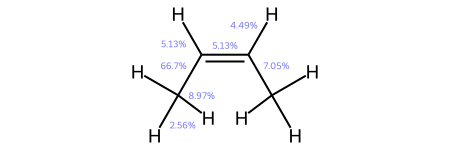

In [48]:
mol = A03.sh.default_mol()

def label_bonds(mol, da):
    for b in mol.GetBonds():
        ai1 = b.GetBeginAtom().GetIdx()
        ai2 = b.GetEndAtom().GetIdx()
        datum = da.sel(atom1=ai1, atom2=ai2).item()
        if datum != 0:
            b.SetProp("bondNote", f"{datum:.3}%")
    return mol

label_bonds(mol, display_data)

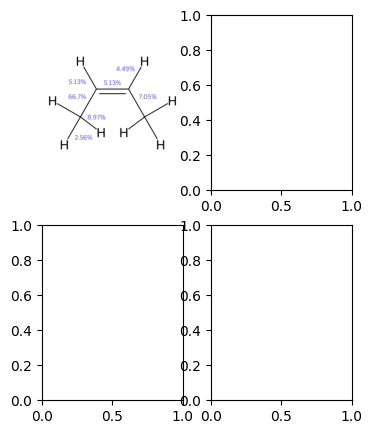

In [56]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2)
fig.set_size_inches(4, 5)
png = sh.rd.mol_to_png(mol)
sh.dynamic.pca_biplot.mpl_imshow_png(axs[0,0], png)

In [ ]:
for (cn, co) in cutoffs.items():
    nreasons = co.sizes['cutoff']
    typefreqs = np.bincount(co.argmin('cutoff'), minlength=nreasons)
    display_data = co['cutoff'].copy(data=typefreqs)
    display_data = 100*display_data / display_data.sum()
    mol = cpnds[cn].sh.default_mol()
    display(label_bonds(mol, display_data))

## Which bonds break at all, and how often?

In [ ]:
masks['A03'].groupby('trajid').all('frame').sum('trajid')

In [ ]:
for (cn, mask) in masks.items():
    display_data = (~mask.groupby('trajid').all('frame')).sum('trajid')
    display_data = 100*display_data / display_data.sum()
    mol = cpnds[cn].sh.default_mol()
    display(label_bonds(mol, display_data))


## Usual statistics

KeyError: "No variable named 'earliest'. Variables on the dataset include ['trajid', 'bond', 'bond_type', 'atom1', 'atom2', 'most_frequent', <this-array>]"

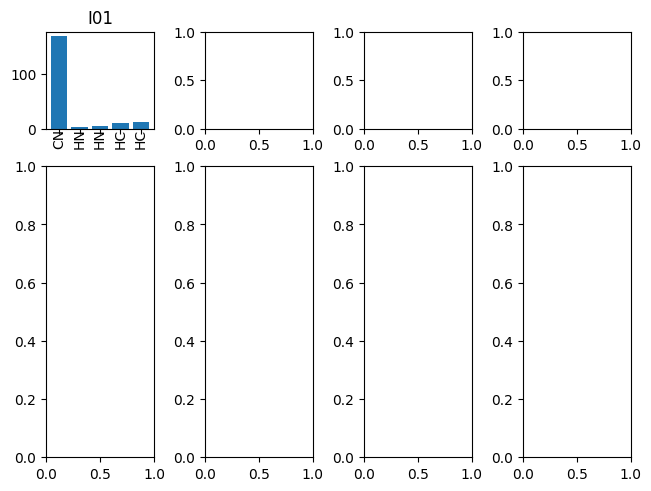

In [34]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2, 4, sharey=False, constrained_layout=True, height_ratios=[1, 3])
for (cn, c), axcol in zip(cutoffs.items(), axs.T):
    nreasons = c.sizes['bond']
    typefreqs = np.bincount(c.argmin('bond'), minlength=nreasons)
    xticks = range(nreasons)
    axcol[0].bar(xticks, typefreqs)
    axcol[0].set_xticks(xticks)
    axcol[0].set_xticklabels(labels=c['bond_type'].data, rotation=90, ha='center', va='center')
    axcol[0].set_title(cn)

    c['most_frequent'] = 'trajid', c.isel(bond=typefreqs.argmax()).data
    c = c.sortby(['earliest', 'most_frequent'])
    xticks = np.arange(c.sizes['trajid'])
    for ctn, ctv in c.groupby('bond'):
        ctv = ctv.squeeze()
        axcol[1].barh(xticks, ctv, height=1.0, alpha=0.2)
    
    axs[0,0].set_ylabel("# trajs truncated\nfor given reason")
    axs[1,0].set_ylabel("$t$ / fs")
    for ax in axs[1, :]:
        ax.set_xlabel("# trajs with this cutoff")